In [1]:
%load_ext autoreload
%autoreload

In [2]:
import os
os.chdir('../')

from absl import flags
from jax import config
import numpy as np
import torch
import cv2
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from PIL import Image
from tqdm import tqdm
from copy import deepcopy
import svox

from octree.nerf import models
from octree.nerf import utils
from octree.nerf import datasets
from db_utils import render_and_show, xyzrpy2c2w, speedtest, lighten_tree

FLAGS = flags.FLAGS
utils.define_flags()
flags.DEFINE_string("input", "./tree.npz", "Input octree npz")
config.parse_flags_with_absl()

FLAGS.input = '../plenoxel/opt/ckpt/lego/ckpt_svox1.npz'
FLAGS.config = 'nerf_sh/config/blender'
FLAGS.data_dir = '../data/blender/lego'
utils.update_flags(FLAGS)
utils.set_random_seed(20200823)
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = datasets.get_dataset("test", FLAGS)
w, h, focal = dataset.w, dataset.h, dataset.focal

# https://github.com/sxyu/svox2/blob/master/opt/util/nerf_dataset.py#L47
dataset.camtoworlds[:,:3,3] /= 1.5

 Load Blender ../data/blender/lego split test


100%|█████████████████████████████████████████████| 200/200 [00:04<00:00, 41.01it/s]


In [3]:
t = svox.N3Tree.load(FLAGS.input, map_location=device)
r = svox.VolumeRenderer(t, step_size=FLAGS.renderer_step_size, ndc=None)
print(t.shape, t.data.shape)

/root/venv/svox/lib/python3.9/site-packages/svox/svox.py:911: UserWarning: map_location has been renamed to device and may be removed
  warn('map_location has been renamed to device and may be removed')


torch.Size([6008878, 28]) torch.Size([858411, 2, 2, 2, 28])


In [4]:
count = 0
for depth in range(t.depth_limit):
    c = (t.depths==depth).sum()
    print(depth, c)
    count += c
print(count)

0 tensor(0, device='cuda:0')
1 tensor(10, device='cuda:0')
2 tensor(247, device='cuda:0')
3 tensor(894, device='cuda:0')
4 tensor(1993, device='cuda:0')
5 tensor(5757, device='cuda:0')
6 tensor(22544, device='cuda:0')
7 tensor(95841, device='cuda:0')
8 tensor(5881592, device='cuda:0')
9 tensor(0, device='cuda:0')
tensor(6008878, device='cuda:0')


  0%|                                                       | 0/200 [00:00<?, ?it/s]

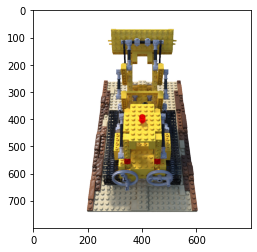

100%|████████████████████████████████████████████| 200/200 [00:01<00:00, 145.58it/s]


In [5]:
speedtest(r, dataset)

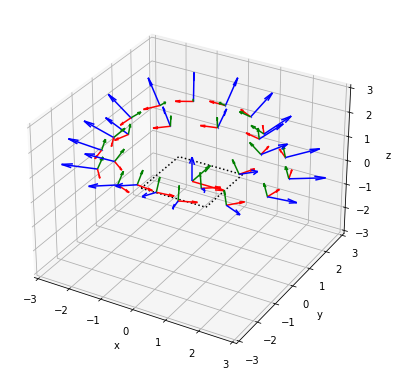

In [6]:
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig, auto_add_to_figure=False)
ax.set_xlim(-3, 3); ax.set_ylim(-3, 3); ax.set_zlim(-3, 3)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.quiver(0, 0, 0, 1, 0, 0, length=1, color="r")
ax.quiver(0, 0, 0, 0, 1, 0, length=1, color="g")
ax.quiver(0, 0, 0, 0, 0, 1, length=1, color="b")
ax.plot([-1,1,1,-1,-1], [-1,-1,1,1,-1], [0,0,0,0,0], color="k", linestyle=":")

for i in range(0,200,8):
    c2w = deepcopy(dataset.camtoworlds[i])
    # blender camera coordinate -> opencv camera coordinate
    # c2w[:3,:3] = c2w[:3,:3].dot(
    #     Rotation.from_euler('xyz', (180,0,0), degrees=True).as_matrix())

    if True:  # xyzrpy2c2w test
        xyz = c2w[:3,3]
        rpy = np.array(cv2.RQDecomp3x3(c2w[:3,:3])[0])
        c2w_ = xyzrpy2c2w(xyz,rpy)
        assert np.sum(c2w - c2w_) < 1e-5

    x, y, z = c2w[:3,3]
    ax.scatter(x, y, z, c='blue', s=0.1)
    x_c = np.array([[1,0,0]]).T; x_w = c2w[:3,:3].dot(x_c)
    dx, dy, dz = x_w[:,0]
    ax.quiver(x, y, z, dx, dy, dz, length=0.5, color="r")
    x_c = np.array([[0,1,0]]).T; x_w = c2w[:3,:3].dot(x_c)
    dx, dy, dz = x_w[:,0]
    ax.quiver(x, y, z, dx, dy, dz, length=0.5, color="g")
    x_c = np.array([[0,0,1]]).T; x_w = c2w[:3,:3].dot(x_c)
    dx, dy, dz = x_w[:,0]
    ax.quiver(x, y, z, dx, dy, dz, length=1., color="b")

fig.add_axes(ax)
plt.show()

---

In [7]:
%autoreload

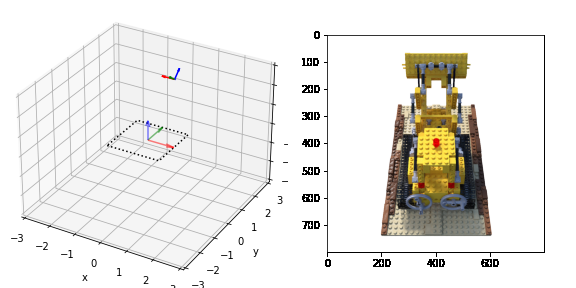

In [8]:
c2w = dataset.camtoworlds[0]
render_and_show(r, c2w, w, h, focal)

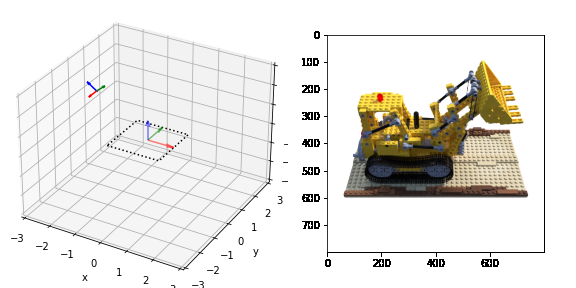

In [9]:
c2w = dataset.camtoworlds[25]
render_and_show(r, c2w, w, h, focal)

---

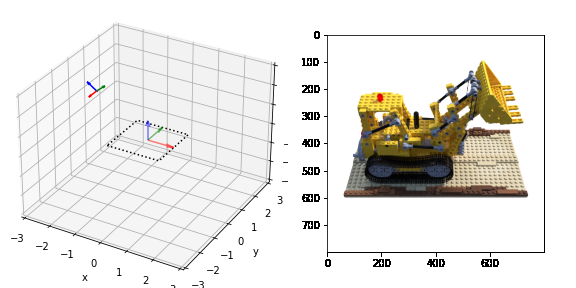

In [10]:
t = svox.N3Tree.load(FLAGS.input, map_location=device)
r = svox.VolumeRenderer(t, step_size=FLAGS.renderer_step_size, ndc=None)
c2w = dataset.camtoworlds[25]
render_and_show(r, c2w, w, h, focal)

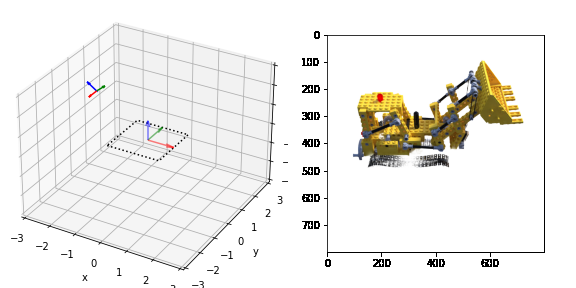

In [11]:
with torch.no_grad():
    t[t.corners[:,2] < 0, -1] = 0  # z座標
c2w = dataset.camtoworlds[25]
render_and_show(r, c2w, w, h, focal)

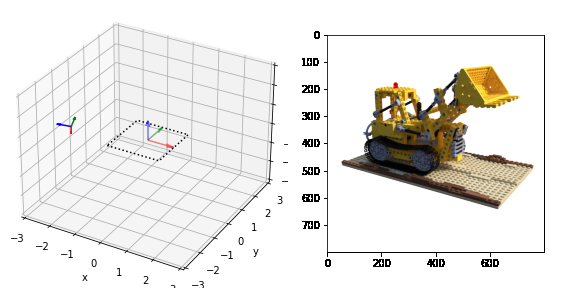

In [12]:
t = svox.N3Tree.load(FLAGS.input, map_location=device)
r = svox.VolumeRenderer(t, step_size=FLAGS.renderer_step_size, ndc=None)
c2w = dataset.camtoworlds[134]
render_and_show(r, c2w, w, h, focal)

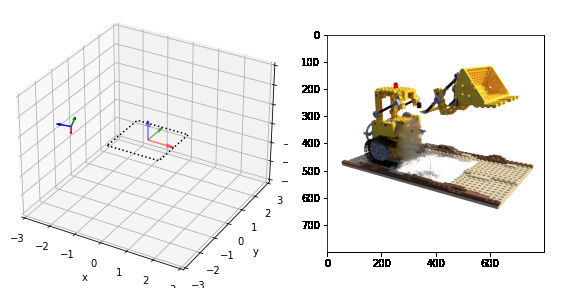

In [13]:
with torch.no_grad():
    t[
        (-0.3 < t.corners[:,0].cpu().numpy()) & \
        (t.corners[:,0].cpu().numpy() < 0.3) & \
        (-0.3 < t.corners[:,1].cpu().numpy()) & \
        (t.corners[:,1].cpu().numpy() < 0.3) & \
        (-0.3 < t.corners[:,2].cpu().numpy()) & \
        (t.corners[:,2].cpu().numpy() < 0.3),
        -1 
    ] = 0
c2w = dataset.camtoworlds[134]
render_and_show(r, c2w, w, h, focal)

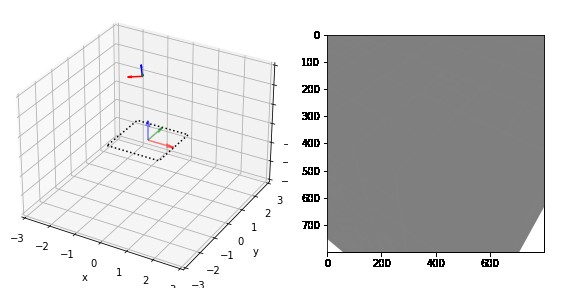

In [14]:
t = svox.N3Tree.load(FLAGS.input, map_location=device)
r = svox.VolumeRenderer(t, step_size=FLAGS.renderer_step_size, ndc=None)
with torch.no_grad():
    t[:,-1] = 100
c2w = dataset.camtoworlds[10]
render_and_show(r, c2w, w, h, focal)

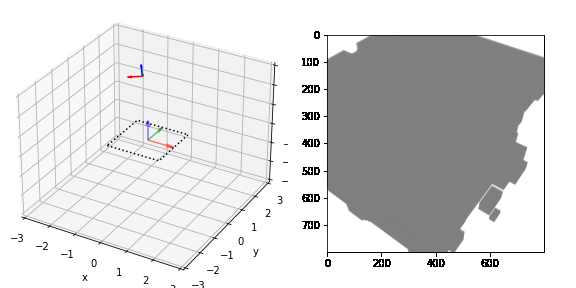

In [15]:
lighten_tree(t, 0.7)
c2w = dataset.camtoworlds[10]
render_and_show(r, c2w, w, h, focal)

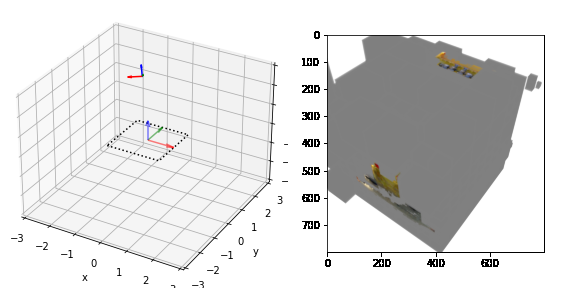

In [16]:
lighten_tree(t, 0.6)
c2w = dataset.camtoworlds[10]
render_and_show(r, c2w, w, h, focal)

  0%|                                                       | 0/200 [00:00<?, ?it/s]

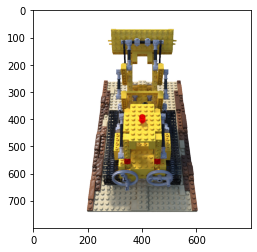

  0%|                                                       | 0/200 [00:00<?, ?it/s]

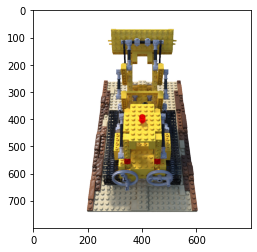

100%|████████████████████████████████████████████| 200/200 [00:01<00:00, 139.43it/s]


In [17]:
t = svox.N3Tree.load(FLAGS.input, map_location=device)
r = svox.VolumeRenderer(t, step_size=FLAGS.renderer_step_size, ndc=None)
speedtest(r, dataset)

t =lighten_tree(t, 0.8)
speedtest(r, dataset)  # Not much change?